In [1]:
# !gdown 'https://drive.google.com/uc?id=10f3jNWltQyham_ebppXWfmyMftcFm8KS' -O '/home/crueang/Chaks/AIOT_project/data/office-31.zip'
# !unzip '/home/crueang/Chaks/AIOT_project/data/Office-31.zip'

In [1]:
DATASET_DIR = '/home/crueang/Chaks/AIOT_project/data/Office-31'
HOME = '/home/crueang/Chaks/AIOT_project'

NUM_CLASSES = 31
BATCH_SIZE = 16
IMAGE_SIZE = 224

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import mobilenet_v3_large, mobilenet_v3_small
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import torchvision
from torch.utils.data import Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms(),
])

amazon_dataset = ImageFolder(root=f'{DATASET_DIR}/amazon', transform=transform)
dslr_dataset = ImageFolder(root=f'{DATASET_DIR}/dslr', transform=transform)
webcam_dataset = ImageFolder(root=f'{DATASET_DIR}/webcam', transform=transform)

classes = webcam_dataset.classes


data_loader = DataLoader(amazon_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(classes)

# source_dataset, target_dataset, test_dataset = random_split(labeled_dataset, [1850, 1850, 410])

# print(len(source_dataset), len(target_dataset), len(test_dataset))

# Dl_source = DataLoader(source_dataset, BATCH_SIZE, shuffle=True)
# Dl_target = DataLoader(target_dataset, BATCH_SIZE, shuffle=True)

['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']


In [3]:
# @title FLOPS computation
# Code from https://github.com/Eric-mingjie/rethinking-network-pruning/blob/master/imagenet/l1-norm-pruning/compute_flops.py
import numpy as np
import os

import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable


def print_model_param_nums(model=None):
    if model == None:
        model = torchvision.models.alexnet()
    total = sum([param.nelement() if param.requires_grad else 0 for param in model.parameters()])
    print('  + Number of params: %.4fM' % (total / 1e6))

def count_model_param_flops(model=None, input_res=224, multiply_adds=True, device='cpu'):

    prods = {}
    def save_hook(name):
        def hook_per(self, input, output):
            prods[name] = np.prod(input[0].shape)
        return hook_per

    list_1=[]
    def simple_hook(self, input, output):
        list_1.append(np.prod(input[0].shape))
    list_2={}
    def simple_hook2(self, input, output):
        list_2['names'] = np.prod(input[0].shape)


    list_conv=[]
    def conv_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size[0] * self.kernel_size[1] * (self.in_channels / self.groups)
        bias_ops = 1 if self.bias is not None else 0

        params = output_channels * (kernel_ops + bias_ops)
        # flops = (kernel_ops * (2 if multiply_adds else 1) + bias_ops) * output_channels * output_height * output_width * batch_size

        num_weight_params = (self.weight.data != 0).float().sum()
        flops = (num_weight_params * (2 if multiply_adds else 1) + bias_ops * output_channels) * output_height * output_width * batch_size

        list_conv.append(flops)

    list_linear=[]
    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1

        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()

        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    list_bn=[]
    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement() * 2)

    list_relu=[]
    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    list_pooling=[]
    def pooling_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size * self.kernel_size
        bias_ops = 0
        params = 0
        flops = (kernel_ops + bias_ops) * output_channels * output_height * output_width * batch_size

        list_pooling.append(flops)

    list_upsample=[]

    # For bilinear upsample
    def upsample_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        flops = output_height * output_width * output_channels * batch_size * 12
        list_upsample.append(flops)

    def foo(net):
        childrens = list(net.children())
        if not childrens:
            if isinstance(net, torch.nn.Conv2d):
                net.register_forward_hook(conv_hook)
            if isinstance(net, torch.nn.Linear):
                net.register_forward_hook(linear_hook)
            if isinstance(net, torch.nn.BatchNorm2d):
                net.register_forward_hook(bn_hook)
            if isinstance(net, torch.nn.ReLU):
                net.register_forward_hook(relu_hook)
            if isinstance(net, torch.nn.MaxPool2d) or isinstance(net, torch.nn.AvgPool2d):
                net.register_forward_hook(pooling_hook)
            if isinstance(net, torch.nn.Upsample):
                net.register_forward_hook(upsample_hook)
            return
        for c in childrens:
            foo(c)

    if model == None:
        model = torchvision.models.alexnet()
    foo(model)
    input = Variable(torch.rand(3,input_res,input_res).unsqueeze(0), requires_grad = True).to(device)
    out = model(input)


    total_flops = (sum(list_conv) + sum(list_linear) + sum(list_bn) + sum(list_relu) + sum(list_pooling) + sum(list_upsample))

    print('Number of FLOPs: %.6f GFLOPs (%.2f MFLOPs)' % (total_flops / 1e9, total_flops / 1e6))

    return total_flops

In [5]:
mbv_3_small_ref = mobilenet_v3_small(weights='DEFAULT')
mbv_3_small_ref.classifier[-1] = nn.Linear(mbv_3_small_ref.classifier[-1].in_features, NUM_CLASSES)
mbv_3_small_ref = mbv_3_small_ref.to(device)
summary(mbv_3_small_ref, (3, IMAGE_SIZE, IMAGE_SIZE))
count_model_param_flops(model=mbv_3_small_ref.cpu().eval(), input_res=IMAGE_SIZE, multiply_adds=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

tensor(1.1434e+08)

In [7]:
train_set, test_set = torch.utils.data.random_split(dslr_dataset, [0.8,0.2])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mbv_3_small_ref.parameters(), lr=0.001)

num_epochs = 10
check_point_path = f'{HOME}/cp/baseline/mbv3_small_ref2/'

In [12]:
import os
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    training_logs = {"train_loss": [], "validate_loss": [], "train_acc": [], "validate_acc": []}
    epoch_number = 0
    best_test_loss = float('inf')
    model = model.to(device)

    if checkpoint_path:
      if os.path.exists(checkpoint_path + 'model.pth'):
        model.load_state_dict(torch.load(checkpoint_path + 'model.pth', weights_only=True, map_location=device))

      if os.path.exists(checkpoint_path + 'opt.pth'):
        opt.load_state_dict(torch.load(checkpoint_path + 'opt.pth', weights_only=True, map_location=device))

      if os.path.exists(checkpoint_path + 'training_logs.pth'):
        training_logs = torch.load(checkpoint_path + 'training_logs.pth', weights_only=True)
        epoch_number = len(training_logs['train_loss'])
        best_test_loss = min(best_test_loss, min(training_logs['validate_loss']))
        print('best_test_acc', max(training_logs['validate_acc']))

    for i in range(epoch_number):
        print(f"Epochs {i+1}".ljust(10), end='')
        for k, v in training_logs.items():
            print(f"{k}: {v[i]:.5f}", end=" ")
        print()

    print("🤖Training on", device)
    for epoch in range(epoch_number, epochs):

        train_loss, train_correct = 0, 0
        model.train()
        train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, label in train_bar:
            images = images.to(device)
            label = label.to(device)
            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, label)
            loss.backward()
            opt.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == label).float().sum().item()
            
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_correct / len(train_loader.dataset)
        print(f'\n\tTrain loss: {avg_train_loss}')
        print(f'\tTrain acc: {avg_train_acc}')
        training_logs["train_loss"].append(avg_train_loss)
        training_logs["train_acc"].append(avg_train_acc)

        test_loss, test_correct = 0, 0
        model.eval()
        test_bar = tqdm(test_loader,desc='📄Testing',unit='batch')
        with torch.no_grad():
          for images, label in test_bar:
            images = images.to(device)
            label = label.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, label)

            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == label).float().sum().item()
            
        avg_test_loss = test_loss / len(test_loader.dataset)
        avg_test_acc = test_correct / len(test_loader.dataset)
        print(f'\tTest loss: {avg_test_loss}')
        print(f'\tTest acc: {avg_test_acc}')
        training_logs["validate_loss"].append(avg_test_loss)
        training_logs["validate_acc"].append(avg_test_acc)

        if checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path + "model.pth")
            torch.save(opt.state_dict(), checkpoint_path + "opt.pth")
            torch.save(training_logs, checkpoint_path + 'training_logs.pth')
            if best_test_loss > avg_test_loss:
               torch.save(model.state_dict(), checkpoint_path + "best_model.pth")
               best_test_loss = avg_test_loss

In [13]:
train(mbv_3_small_ref, optimizer, criterion, train_loader, test_loader, 50, checkpoint_path=check_point_path, device=device)

best_test_acc 0.9696969696969697
Epochs 1  train_loss: 0.12932 validate_loss: 0.10538 train_acc: 0.47870 validate_acc: 0.59596 
Epochs 2  train_loss: 0.01843 validate_loss: 0.06013 train_acc: 0.93734 validate_acc: 0.78788 
Epochs 3  train_loss: 0.00409 validate_loss: 0.04757 train_acc: 0.98997 validate_acc: 0.79798 
Epochs 4  train_loss: 0.00227 validate_loss: 0.01379 train_acc: 0.99248 validate_acc: 0.95960 
Epochs 5  train_loss: 0.00072 validate_loss: 0.00962 train_acc: 1.00000 validate_acc: 0.96970 
Epochs 6  train_loss: 0.00052 validate_loss: 0.01484 train_acc: 1.00000 validate_acc: 0.92929 
Epochs 7  train_loss: 0.00037 validate_loss: 0.00712 train_acc: 1.00000 validate_acc: 0.95960 
Epochs 8  train_loss: 0.00119 validate_loss: 0.02715 train_acc: 0.99248 validate_acc: 0.90909 
Epochs 9  train_loss: 0.00136 validate_loss: 0.08175 train_acc: 0.98997 validate_acc: 0.77778 
Epochs 10 train_loss: 0.01104 validate_loss: 0.06109 train_acc: 0.94987 validate_acc: 0.72727 
Epochs 11 train_l

In [23]:
mbv_3_large_ref = mobilenet_v3_large(weights=None, num_classes=31)
# mbv_3_large_ref.classifier[-1] = nn.Linear(mbv_3_large_ref.classifier[-1].in_features, NUM_CLASSES)
mbv_3_large_ref = mbv_3_large_ref.to(device)
summary(mbv_3_large_ref, (3, IMAGE_SIZE, IMAGE_SIZE))
count_model_param_flops(model=mbv_3_large_ref.cpu().eval(), input_res=64, multiply_adds=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         Hardswish-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]             144
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             256
       BatchNorm2d-8           [-1, 16, 32, 32]              32
  InvertedResidual-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]           1,024
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]             576
      BatchNorm2d-14           [-1, 64,

tensor(41171960.)

In [38]:
train_set, test_set = torch.utils.data.random_split(dslr_dataset, [0.8,0.2])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mbv_3_small_ref.parameters(), lr=0.001)

num_epochs = 10
check_point_path = f'{HOME}/cp/baseline/mbv3_large_ref/'

In [25]:
train(mbv_3_large_ref, optimizer, criterion, train_loader, test_loader, 50, check_point_path, device)

🤖Training on cuda


🚀Training Epoch [1/50]:   0%|          | 0/25 [00:00<?, ?batch/s]

🚀Training Epoch [1/50]:  44%|████▍     | 11/25 [00:02<00:02,  5.17batch/s]


KeyboardInterrupt: 

In [11]:
class LTAEBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4, dropout=0.1):
        super(LTAEBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.fc1 = nn.Linear(embed_dim, embed_dim * mlp_ratio)
        self.fc2 = nn.Linear(embed_dim * mlp_ratio, embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.fc2(self.dropout2(F.gelu(self.fc1(x))))
        x = self.norm2(x + ff_output)
        return x

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio, activation, use_ltae=False):
        super(InvertedResidual, self).__init__()
        self.use_ltae = use_ltae
        hidden_channels = in_channels * expand_ratio
        activation_layer = nn.Hardswish() if activation == "HS" else nn.ReLU()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=1),
            nn.BatchNorm2d(hidden_channels),
            activation_layer,
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=stride, padding=1, groups=hidden_channels),
            nn.BatchNorm2d(hidden_channels),
            activation_layer
        )

        if use_ltae:
            self.ltae = LTAEBlock(embed_dim=hidden_channels, num_heads=expand_ratio)
        
        self.pointwise = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            activation_layer
        )

    def forward(self, x):
        x = self.conv(x)  # Apply convolution
        if self.use_ltae:
            batch_size, channels, height, width = x.size()
            # Reshape x for LTAE block
            x = x.view(batch_size, channels, -1).permute(0, 2, 1)  # (batch, height*width, channels)
            x = self.ltae(x)  # Apply LTAE
            x = x.permute(0, 2, 1).view(batch_size, channels, height, width)  # Reshape back
            
        x = self.pointwise(x)
        return x
        
class LTAEMobileNetV3Small(nn.Module):
    def __init__(self, num_classes=1000):
        super(LTAEMobileNetV3Small, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.hs = nn.Hardsigmoid()

        # Define layers of MobileNetV3 Small with inverted residual blocks and LTAE replacing SE
        self.blocks = nn.ModuleList([
            InvertedResidual(16, 16, stride=1, expand_ratio=1, activation="RE", use_ltae=True),
            InvertedResidual(16, 24, stride=2, expand_ratio=1, activation="RE", use_ltae=False),
            InvertedResidual(24, 24, stride=1, expand_ratio=1, activation="RE", use_ltae=False),
            InvertedResidual(24, 40, stride=2, expand_ratio=3, activation="HS", use_ltae=True),
            InvertedResidual(40, 40, stride=1, expand_ratio=3, activation="HS", use_ltae=True),
            InvertedResidual(40, 40, stride=2, expand_ratio=3, activation="HS", use_ltae=True),
            InvertedResidual(40, 48, stride=1, expand_ratio=3, activation="HS", use_ltae=True),
            InvertedResidual(48, 48, stride=1, expand_ratio=3, activation="HS", use_ltae=True),
            InvertedResidual(48, 96, stride=1, expand_ratio=3, activation="HS", use_ltae=True),
            InvertedResidual(96, 96, stride=1, expand_ratio=3, activation="HS", use_ltae=True),
            InvertedResidual(96, 96, stride=2, expand_ratio=3, activation="HS", use_ltae=True),
        ])
        
        self.conv2 = nn.Conv2d(96, 576, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(576)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(576, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.hs(self.bn1(self.conv1(x)))
        for block in self.blocks:
            x = block(x)
        
        # conv2 with LTAE
        x = self.conv2(x)
        x = self.hs(x)
        # batch_size, channels, height, width = x.size()
        # x = x.view(batch_size, channels, -1).permute(0, 2, 1)
        # x = self.ltae(x)
        # x = x.permute(0, 2, 1).view(batch_size, channels, height, width)
        # x = self.hs(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.hs(self.fc1(x))
        self.dropout(x)
        x = self.fc2(x)
        return x

In [12]:
mbv3_small_LTAE = LTAEMobileNetV3Small(num_classes=NUM_CLASSES).to(device)
summary(mbv3_small_LTAE, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
       BatchNorm2d-2         [-1, 16, 112, 112]              32
       Hardsigmoid-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             272
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
              ReLU-7         [-1, 16, 112, 112]               0
            Conv2d-8         [-1, 16, 112, 112]             160
       BatchNorm2d-9         [-1, 16, 112, 112]              32
             ReLU-10         [-1, 16, 112, 112]               0
             ReLU-11         [-1, 16, 112, 112]               0
MultiheadAttention-12  [[-1, 12544, 16], [-1, 2, 2]]               0
          Dropout-13            [-1, 12544, 16]               0
        LayerNorm-14            [-

In [ ]:
# optimizer = torch.optim.Adam(mbv3_small_LTAE.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
# check_point_path = f'{HOME}/cp/mbv3_small_LTAE/'

# train(mbv3_small_LTAE, optimizer, criterion, train_loader, test_loader, 10, checkpoint_path=check_point_path, device=device)

In [39]:
mbv3_reduce = mobilenet_v3_small(weights=None, width_mult=0.25, num_classes=31)
# mbv_3_small_ref.classifier[-1] = nn.Linear(mbv_3_small_ref.classifier[-1].in_features, NUM_CLASSES)
mbv3_reduce = mbv3_reduce.to(device)
summary(mbv3_reduce, (3, IMAGE_SIZE, IMAGE_SIZE))
count_model_param_flops(model=mbv3_reduce.cpu().eval(), input_res=IMAGE_SIZE, multiply_adds=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]             216
       BatchNorm2d-2            [-1, 8, 64, 64]              16
         Hardswish-3            [-1, 8, 64, 64]               0
            Conv2d-4            [-1, 8, 32, 32]              72
       BatchNorm2d-5            [-1, 8, 32, 32]              16
              ReLU-6            [-1, 8, 32, 32]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 32, 32]               0
           Conv2d-13            [-1, 8, 32, 32]              64
      BatchNorm2d-14            [-1, 8,

tensor(6198479.)

In [42]:
# train_set, test_set = torch.utils.data.random_split(dslr_dataset, [0.8,0.2])
train_loader = DataLoader(amazon_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dslr_dataset, batch_size=16, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mbv3_reduce.parameters(), lr=0.001)

check_point_path = f'{HOME}/newcp/pre2/'

In [43]:
train(mbv3_reduce, optimizer, criterion, train_loader, test_loader, 100, checkpoint_path=check_point_path, device=device)

🤖Training on cuda


🚀Training Epoch [1/100]: 100%|██████████| 226/226 [00:16<00:00, 13.56batch/s]



	Train loss: 0.16299070115897346
	Train acc: 0.27879291251384275


📄Testing: 100%|██████████| 32/32 [00:05<00:00,  6.05batch/s]


	Test loss: 0.21019215504807162
	Test acc: 0.15060240963855423


🚀Training Epoch [2/100]: 100%|██████████| 226/226 [00:17<00:00, 13.13batch/s]



	Train loss: 0.13301405663770166
	Train acc: 0.4003322259136213


📄Testing: 100%|██████████| 32/32 [00:05<00:00,  5.99batch/s]


	Test loss: 0.21945139945271502
	Test acc: 0.142570281124498


🚀Training Epoch [3/100]: 100%|██████████| 226/226 [00:16<00:00, 13.41batch/s]



	Train loss: 0.11889225478848217
	Train acc: 0.4601328903654485


📄Testing: 100%|██████████| 32/32 [00:05<00:00,  6.17batch/s]


	Test loss: 0.2164306534102643
	Test acc: 0.20682730923694778


🚀Training Epoch [4/100]: 100%|██████████| 226/226 [00:16<00:00, 13.42batch/s]



	Train loss: 0.1051649580630221
	Train acc: 0.5274086378737541


📄Testing: 100%|██████████| 32/32 [00:05<00:00,  6.26batch/s]


	Test loss: 0.18789321734723316
	Test acc: 0.20883534136546184


🚀Training Epoch [5/100]: 100%|██████████| 226/226 [00:16<00:00, 13.54batch/s]



	Train loss: 0.09432869311318973
	Train acc: 0.563953488372093


📄Testing: 100%|██████████| 32/32 [00:05<00:00,  6.11batch/s]


	Test loss: 0.19792726276868797
	Test acc: 0.21485943775100402


🚀Training Epoch [6/100]: 100%|██████████| 226/226 [00:16<00:00, 13.49batch/s]



	Train loss: 0.08595663889962045
	Train acc: 0.5985603543743079


📄Testing: 100%|██████████| 32/32 [00:05<00:00,  6.11batch/s]


	Test loss: 0.19779770465261007
	Test acc: 0.2429718875502008


🚀Training Epoch [7/100]: 100%|██████████| 226/226 [00:16<00:00, 13.59batch/s]



	Train loss: 0.07808307932064779
	Train acc: 0.6273532668881506


📄Testing: 100%|██████████| 32/32 [00:05<00:00,  6.17batch/s]


	Test loss: 0.22456915024293952
	Test acc: 0.21686746987951808


🚀Training Epoch [8/100]:  77%|███████▋  | 174/226 [00:12<00:03, 13.41batch/s]


KeyboardInterrupt: 

In [245]:
import torch
import torch.nn.functional as F
from torch.autograd import Function

# Gradient Reversal Layer for DANN
class GradientReversal(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

# Domain classifier for DANN
class DomainClassifier(nn.Module):
    def __init__(self):
        super(DomainClassifier, self).__init__()
        
        # Classify domain based on features
        self.domain_classifier = nn.Sequential(
            nn.Linear(144, 256),
            nn.ReLU(),
            nn.Linear(256, 2)  # Binary output (0: source, 1: target)
        )
        
    def forward(self, features, alpha):
        # Apply gradient reversal to the features
        reversed_features = GradientReversal.apply(features, alpha)
        
        # Classify the domain
        domain_output = self.domain_classifier(reversed_features)
        return domain_output

In [246]:
class StudentModelMBV3SmallReduce(nn.Module):
    def __init__(self):
        super(StudentModelMBV3SmallReduce, self).__init__()
        self.mbv3 = mobilenet_v3_small(weights=None, width_mult=0.25, num_classes=NUM_CLASSES)
        
    def forward(self, x):
        x = self.mbv3.features(x)
        x = self.mbv3.avgpool(x)
        features = x.view(x.size(0), -1)
        x = self.mbv3.classifier(features)
        return x, features

In [256]:
def train_dann(student_model, teacher_model, domain_classifier, source_loader, target_loader,
               num_epochs,
               optimizer, criterion_class, criterion_domain, alpha, temperature, checkpoint_path, device):
    
    training_logs = {"train_loss": [], "train_src_acc": [], "train_tar_acc": []}
    epoch_number = 0
    best_test_loss = float('inf')
    
    student_model.to(device)
    teacher_model.to(device)
    domain_classifier.to(device)
    
    for param in teacher_model.parameters():
        param.requires_grad = False
    
    if checkpoint_path:
      if os.path.exists(checkpoint_path + 'model.pth'):
        student_model.load_state_dict(torch.load(checkpoint_path + 'model.pth', weights_only=True, map_location=device))

      if os.path.exists(checkpoint_path + 'opt.pth'):
        optimizer.load_state_dict(torch.load(checkpoint_path + 'opt.pth', weights_only=True, map_location=device))

      if os.path.exists(checkpoint_path + 'training_logs.pth'):
        training_logs = torch.load(checkpoint_path + 'training_logs.pth', weights_only=True)
        epoch_number = len(training_logs['train_loss'])
        best_test_loss = min(best_test_loss, min(training_logs['test_loss']))
    
    for i in range(epoch_number):
        print(f"Epochs {i+1}".ljust(10), end='')
        for k, v in training_logs.items():
            print(f"{k}: {v[i]:.5f}", end=" ")
        print()
        
    for epoch in range(epoch_number,num_epochs):
        student_model.train()
        domain_classifier.train()
        
        p = epoch / num_epochs
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        train_loss, train_src_correct, train_tar_correct = 0, 0, 0
        for (source_data, source_labels), (target_data, target_labels) in zip(source_loader, target_loader):
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data, target_labels = target_data.to(device), target_labels.to(device)
            
            # Forward pass through student model for source domain
            class_output, source_features = student_model(source_data)
            loss_classification = criterion_class(class_output, source_labels)
            
            # Forward pass through student model for target domain (just features)
            _, target_features = student_model(target_data)
            
            # Domain classifier loss (DANN)
            domain_output_source = domain_classifier(source_features, alpha)
            domain_output_target = domain_classifier(target_features, alpha)
            
            domain_labels_source = torch.zeros(source_data.size(0)).long().to(device)
            domain_labels_target = torch.ones(target_data.size(0)).long().to(device)
            
            loss_domain_source = criterion_domain(domain_output_source, domain_labels_source)
            loss_domain_target = criterion_domain(domain_output_target, domain_labels_target)
            loss_domain = (loss_domain_source + loss_domain_target) / 2
            
            # Knowledge distillation loss
            with torch.no_grad():
                teacher_output = teacher_model(source_data)
                
            loss_distillation = F.kl_div(
                F.log_softmax(class_output / temperature, dim=1),
                F.softmax(teacher_output / temperature, dim=1),
                reduction='batchmean'
            ) * (temperature ** 2)

            # Total loss
            loss = loss_classification + loss_domain + loss_distillation
            
            loss = loss_classification + loss_domain

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
              class_prediction_s, _ = student_model(source_data)
              class_prediction_t, _ = student_model(target_data)
            
            print(f'[{epoch}] '
                  f'class loss: {loss_classification.item():.4f} '
                  f'source_domain_loss: {loss_domain_source.item():.4f} '
                  f'target_domain_loss: {loss_domain_target.item():.4f} '
                  f'grl_lambda: {alpha:.3f}'
                  )

            train_loss += loss.item()
            train_src_correct += (class_prediction_s.argmax(1) == source_labels).float().sum().item()
            train_tar_correct += (class_prediction_t.argmax(1) == target_labels).float().sum().item()


        training_logs["train_src_acc"].append(train_src_correct / len(source_loader.dataset))#.dataset))
        training_logs["train_tar_acc"].append(train_tar_correct / len(target_loader.dataset))#.dataset))
        training_logs["train_loss"].append(train_loss / len(source_loader))
        
        print(f'Epoch: {epoch} || \
        Train_src_acc: {train_src_correct / len(Dl_source.dataset)}, \
        Train_tar_acc: {train_tar_correct / len(Dl_target.dataset)}, \
        Train_loss: {train_loss / len(Dl_source)}'
        )
        
        if checkpoint_path:
            torch.save(student_model.state_dict(), checkpoint_path + "model.pth")
            torch.save(optimizer.state_dict(), checkpoint_path + "opt.pth")
            torch.save(training_logs, checkpoint_path + 'training_logs.pth')
            if best_test_loss > train_tar_correct / len(target_loader.dataset):
               torch.save(student_model.state_dict(), checkpoint_path + "best_model.pth")
               best_test_loss = train_tar_correct / len(target_loader.dataset)
        

In [257]:
teacher_model = mobilenet_v3_large(num_classes=NUM_CLASSES).to(device)
teacher_model.load_state_dict(torch.load(f'{HOME}/cp/mbv3_large_ref/best_model.pth', weights_only=True))
# summary(teacher_model, (3, 224, 224))
# student_model = mobilenet_v3_small(weights=None, width_mult=0.25, num_classes=NUM_CLASSES).to(device)
# print(student_model.features)
# print(student_model.avgpool)
student_model = StudentModelMBV3SmallReduce().to(device)
student_model.mbv3.load_state_dict(torch.load(f'{HOME}/cp/mbv3_small_reduce/best_model.pth', weights_only=True))
summary(student_model, (3, 224, 224))
domain_classifier = DomainClassifier()
optim = torch.optim.Adam(student_model.parameters(), lr=0.001)

source_loader = DataLoader(amazon_dataset, batch_size=32, shuffle=True)
target_loader = DataLoader(dslr_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

criterion_class = nn.CrossEntropyLoss()  # For classification task
criterion_domain = nn.CrossEntropyLoss()  # For domain classification task
criterion_distillation = nn.KLDivLoss(reduction='batchmean')

checkpoint_path = f'{HOME}/cp/DANN_A2D/'

alpha = 0.1  # You may want to increase this gradually during training
temperature = 3.0  # For softening the teacher's logits


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

In [258]:
train_dann(student_model, teacher_model, domain_classifier, source_loader, target_loader, 100, optim, criterion, criterion, alpha, temperature, checkpoint_path, device)

[0] class loss: 4.0537 source_domain_loss: 0.7631 target_domain_loss: 0.6261 grl_lambda: 0.000
[0] class loss: 2.4414 source_domain_loss: 0.7607 target_domain_loss: 0.6294 grl_lambda: 0.000
[0] class loss: 3.5196 source_domain_loss: 0.7590 target_domain_loss: 0.6288 grl_lambda: 0.000
[0] class loss: 1.9956 source_domain_loss: 0.7588 target_domain_loss: 0.6332 grl_lambda: 0.000
[0] class loss: 2.1725 source_domain_loss: 0.7588 target_domain_loss: 0.6293 grl_lambda: 0.000
[0] class loss: 2.4339 source_domain_loss: 0.7597 target_domain_loss: 0.6310 grl_lambda: 0.000
[0] class loss: 2.3472 source_domain_loss: 0.7636 target_domain_loss: 0.6288 grl_lambda: 0.000
[0] class loss: 2.7420 source_domain_loss: 0.7625 target_domain_loss: 0.6275 grl_lambda: 0.000
[0] class loss: 2.9229 source_domain_loss: 0.7631 target_domain_loss: 0.6297 grl_lambda: 0.000
[0] class loss: 2.0477 source_domain_loss: 0.7647 target_domain_loss: 0.6292 grl_lambda: 0.000
[0] class loss: 2.1571 source_domain_loss: 0.7624 

KeyboardInterrupt: 

In [259]:
def patch_mix(source, target, alpha=0.8):
    """Mixes patches from source and target images with a bias towards the source."""
    batch_size, _, height, width = target.size()
    patch_size = height // 2  # Assuming we split into 2x2 patches

    # Create a random mask
    rand_mask = torch.rand(batch_size, 1, 1, 1).to(source.device)

    # Use the mask to blend the images, favoring the source
    mixed_images = (rand_mask < alpha) * source + (rand_mask >= alpha) * target
    return mixed_images


In [273]:

def train_patchmix(student_model, teacher_model, opt, loss_fn, source_loader, target_loader, epochs=10, checkpoint_path=None, device='cpu'):
    training_logs = {"train_loss": [], "train_tar_acc": [], "train_src_acc": []}
    epoch_number = 0
    best_test_loss = float('inf')
    student_model.to(device)
    teacher_model.to(device)
    
    for param in teacher_model.parameters():
        param.requires_grad = False

    if checkpoint_path:
      if os.path.exists(checkpoint_path + 'model.pth'):
        student_model.load_state_dict(torch.load(checkpoint_path + 'model.pth', weights_only=True, map_location=device))

      if os.path.exists(checkpoint_path + 'opt.pth'):
        opt.load_state_dict(torch.load(checkpoint_path + 'opt.pth', weights_only=True, map_location=device))

      if os.path.exists(checkpoint_path + 'training_logs.pth'):
        training_logs = torch.load(checkpoint_path + 'training_logs.pth', weights_only=True)
        epoch_number = len(training_logs['train_loss'])
        best_test_loss = min(best_test_loss, min(training_logs['validate_loss']))

    for i in range(epoch_number):
        print(f"Epochs {i+1}".ljust(10), end='')
        for k, v in training_logs.items():
            print(f"{k}: {v[i]:.5f}", end=" ")
        print()

    print("🤖Training on", device)
    for epoch in range(epoch_number, epochs):

        student_model.train()
        train_loss, train_src_correct, train_tar_correct = 0, 0, 0
        for (source_images, source_labels), (target_images, target_labels) in zip(source_loader, target_loader):
            source_labels = source_labels.to(device)
            source_images = source_images.to(device)
            target_labels = target_labels.to(device)
            target_images = target_images.to(device)
            mixed_images = patch_mix(source_images, target_images).to(device)
            opt.zero_grad()
            outputs = student_model(mixed_images)
            loss_classification = loss_fn(outputs, source_labels)
            loss_classification.backward()
            opt.step()
            train_src_correct += (outputs.argmax(1) == source_labels).float().sum().item()
            
            outputs = student_model(target_images)
            train_tar_correct += (outputs.argmax(1) == target_labels).float().sum().item()
            
            # # Knowledge distillation loss
            # with torch.no_grad():
            #     teacher_output = teacher_model(source_images)
                
            # loss_distillation = F.kl_div(
            #     F.log_softmax(outputs / temperature, dim=1),
            #     F.softmax(teacher_output / temperature, dim=1),
            #     reduction='batchmean'
            # ) * (temperature ** 2)

            # # Total loss
            # loss = loss_classification + loss_distillation
            loss = loss_classification
            
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(target_loader.dataset)
        avg_train_src_acc = train_src_correct / len(source_loader.dataset)
        avg_train_tar_acc = train_tar_correct / len(target_loader.dataset)
        print(f'Epoch: {epoch+1} || \
        Train_src_acc: {avg_train_src_acc}, \
        Train_tar_acc: {avg_train_tar_acc}, \
        Train_loss: {avg_train_loss}'
        )
        training_logs["train_loss"].append(avg_train_loss)
        training_logs['train_src_acc'].append(avg_train_src_acc)
        training_logs['train_tar_acc'].append(avg_train_tar_acc)
        # training_logs["train_acc"].append(avg_train_acc)

        # test_loss, test_correct = 0, 0
        # student_model.eval()
        # test_bar = tqdm(test_loader,desc='📄Testing',unit='batch')
        # with torch.no_grad():
        #   for images, label in test_bar:
        #     images = images.to(device)
        #     label = label.to(device)
        #     outputs = student_model(images)
        #     loss = loss_fn(outputs, label)

        #     test_loss += loss.item()
        #     test_correct += (outputs.argmax(1) == label).float().sum().item()
            
        # avg_test_loss = test_loss / len(test_loader.dataset)
        # avg_test_acc = test_correct / len(test_loader.dataset)
        # print(f'\tTest loss: {avg_test_loss}')
        # print(f'\tTest acc: {avg_test_acc}')
        # training_logs["validate_loss"].append(avg_test_loss)
        # training_logs["validate_acc"].append(avg_test_acc)

        if checkpoint_path:
            torch.save(student_model.state_dict(), checkpoint_path + "model.pth")
            torch.save(opt.state_dict(), checkpoint_path + "opt.pth")
            torch.save(training_logs, checkpoint_path + 'training_logs.pth')
            if best_test_loss > avg_train_tar_acc:
               torch.save(student_model.state_dict(), checkpoint_path + "best_model.pth")
               best_test_loss = avg_train_tar_acc

In [274]:
teacher_model = mobilenet_v3_large(num_classes=NUM_CLASSES).to(device)
teacher_model.load_state_dict(torch.load(f'{HOME}/cp/mbv3_large_ref/best_model.pth', weights_only=True))
# summary(teacher_model, (3, 224, 224))
student_model = mobilenet_v3_small(weights=None, width_mult=0.25, num_classes=NUM_CLASSES).to(device)
student_model.load_state_dict(torch.load(f'{HOME}/cp/mbv3_small_reduce/best_model.pth', weights_only=True))
# print(student_model.features)
# print(student_model.avgpool)
# student_model = StudentModelMBV3SmallReduce().to(device)
summary(student_model, (3, 224, 224))
domain_classifier = DomainClassifier()
optim = torch.optim.Adam(student_model.parameters(), lr=0.001)

print(len(amazon_dataset), len(dslr_dataset))

class ExpandDataset(Dataset):
    def __init__(self, original_dataset, required_size):
        self.original_dataset = original_dataset
        self.required_size = required_size
        self.original_size = len(original_dataset)
    
    def __len__(self):
        return self.required_size
    
    def __getitem__(self, idx):
        # Select a random index from the original dataset to duplicate
        original_idx = idx % self.original_size  # Loop around if idx exceeds original size
        return self.original_dataset[original_idx]

expanded_dataset = ExpandDataset(dslr_dataset, 2817)

source_loader = DataLoader(amazon_dataset, batch_size=32, shuffle=True)
target_loader = DataLoader(expanded_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

criterion_class = nn.CrossEntropyLoss()
criterion_distillation = nn.KLDivLoss(reduction='batchmean')

# checkpoint_path = f'{HOME}/cp/student_patchmix/'
# checkpoint_path = f'{HOME}/cp/patchmix/'
checkpoint_path = f'{HOME}/cp/patchmix_pretrainedA2D/'


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

In [275]:
# train_patchmix(student_model, teacher_model, opt, loss_fn, source_loader, target_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu')
train_patchmix(student_model, teacher_model, optim, criterion_class, source_loader, target_loader, epochs=100, checkpoint_path=checkpoint_path, device=device)

🤖Training on cuda
Epoch: 1 ||         Train_src_acc: 0.43485977990770325,         Train_tar_acc: 0.40717074902378414,         Train_loss: 0.09740737528084947
Epoch: 2 ||         Train_src_acc: 0.5303514376996805,         Train_tar_acc: 0.40610578629747957,         Train_loss: 0.05941654368838309
Epoch: 3 ||         Train_src_acc: 0.5818246361377352,         Train_tar_acc: 0.38161164359247424,         Train_loss: 0.04929924072591303


KeyboardInterrupt: 

In [234]:
import cv2
import numpy as np
from skimage.exposure import match_histograms

def histogram_matching(source, target):
    # Convert PyTorch tensors to NumPy arrays
    source_np = source.cpu().detach().numpy()
    target_np = target.cpu().detach().numpy()

    # Initialize a list to hold matched images
    matched_images = []

    # Process each image in the batch
    for i in range(target_np.shape[0]):
        image = np.array(source[i].cpu()*255).astype(np.uint8).transpose(1, 2, 0)
        ref = np.array(target[i].cpu()*255).astype(np.uint8).transpose(1, 2, 0)
        
        matched = torch.tensor(match_histograms(image, ref, channel_axis=-1)).permute(2, 0, 1)
        matched_images.append(matched.unsqueeze(0))


    # Stack matched images into a tensor
    matched_images = torch.cat(matched_images, dim=0).to(source.device)  # Shape (B, H, W)

    return matched_images

torch.Size([16, 3, 256, 256])


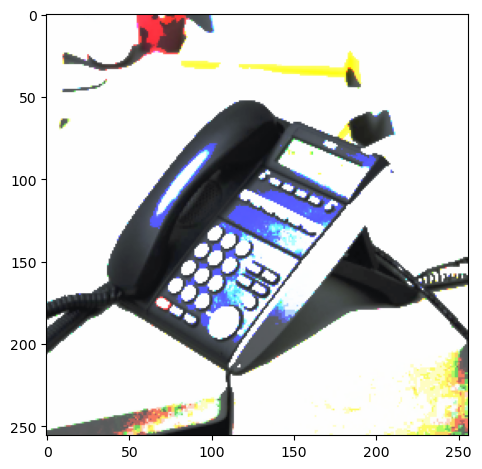

In [235]:
# Example for standard PyTorch images with value ranges of [0-1]
source_loader = DataLoader(source_dataset, batch_size=16, shuffle=True)
batch1 = next(iter(source_loader))
batch2 = next(iter(source_loader))

matched = histogram_matching(batch1[0], batch2[0])

print(matched.shape)

plt.imshow(matched[0].permute(1, 2, 0))

plt.tight_layout()
plt.show()

In [238]:
class MatchedDataset(Dataset):
    def __init__(self, source_dataset, target_dataset, transform=None):
        self.source_dataset = source_dataset
        self.target_dataset = target_dataset
        self.matched_images = []
        self.transform =  transform

        # Apply histogram matching and create matched images
        for source_image, _ in DataLoader(source_dataset, batch_size=1):
            for target_image, _ in DataLoader(target_dataset, batch_size=1):
                matched_image = histogram_matching(source_image, target_image)
                
                if self.transform:
                    matched_image = self.transform(matched_image)
                    
                self.matched_images.append(matched_image)

    def __len__(self):
        return len(self.matched_images)

    def __getitem__(self, idx):
        return self.matched_images[idx]

In [239]:
transform = transforms.Compose([
    torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()
])

transform2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

amazon_dataset = ImageFolder(root=f'{DATASET_DIR}/amazon', transform=transform2)
dslr_dataset = ImageFolder(root=f'{DATASET_DIR}/dslr', transform=transform2)
webcam_dataset = ImageFolder(root=f'{DATASET_DIR}/webcam', transform=transform2)

classes = webcam_dataset.classes


new_source_dataset = MatchedDataset(amazon_dataset, dslr_dataset, transform=transform)
new_source_loader = DataLoader(new_source_dataset, batch_size=BATCH_SIZE, shuffle=True)


KeyboardInterrupt: 

In [197]:
def train_histogram_matching(student_model, teacher_model, opt, loss_fn, source_loader, target_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    training_logs = {"train_loss": [], "validate_loss": [], "train_acc": [], "validate_acc": []}
    epoch_number = 0
    best_test_loss = float('inf')
    student_model.to(device)
    teacher_model.to(device)
    
    for param in teacher_model.parameters():
        param.requires_grad = False

    if checkpoint_path:
      if os.path.exists(checkpoint_path + 'model.pth'):
        student_model.load_state_dict(torch.load(checkpoint_path + 'model.pth', weights_only=True, map_location=device))

      if os.path.exists(checkpoint_path + 'opt.pth'):
        opt.load_state_dict(torch.load(checkpoint_path + 'opt.pth', weights_only=True, map_location=device))

      if os.path.exists(checkpoint_path + 'training_logs.pth'):
        training_logs = torch.load(checkpoint_path + 'training_logs.pth', weights_only=True)
        epoch_number = len(training_logs['train_loss'])
        best_test_loss = min(best_test_loss, min(training_logs['validate_loss']))

    for i in range(epoch_number):
        print(f"Epochs {i+1}".ljust(10), end='')
        for k, v in training_logs.items():
            print(f"{k}: {v[i]:.5f}", end=" ")
        print()

    print("🤖Training on", device)
    for epoch in range(epoch_number, epochs):

        train_loss, train_correct = 0, 0
        student_model.train()
        for (source_images, source_labels), (target_images, _) in zip(source_loader, target_loader):
            source_labels = source_labels.to(device)
            source_images = source_images.to(device)
            target_images = target_images.to(device)
            opt.zero_grad()
            outputs = student_model(source_images)
            loss_classification = loss_fn(outputs, source_labels)
            loss_classification.backward()
            opt.step()
            train_correct += (outputs.argmax(1) == source_labels).float().sum().item()
            
            # # Knowledge distillation loss
            # with torch.no_grad():
            #     teacher_output = teacher_model(source_images)
                
            # loss_distillation = F.kl_div(
            #     F.log_softmax(outputs / temperature, dim=1),
            #     F.softmax(teacher_output / temperature, dim=1),
            #     reduction='batchmean'
            # ) * (temperature ** 2)

            # # Total loss
            # loss = loss_classification + loss_distillation
            loss = loss_classification
            
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc = train_correct / len(train_loader.dataset)
        print(f'\n\tTrain loss: {avg_train_loss}')
        print(f'\tTrain acc: {avg_train_acc}')
        training_logs["train_loss"].append(avg_train_loss)
        training_logs["train_acc"].append(avg_train_acc)

        test_loss, test_correct = 0, 0
        student_model.eval()
        test_bar = tqdm(test_loader,desc='📄Testing',unit='batch')
        with torch.no_grad():
          for images, label in test_bar:
            images = images.to(device)
            label = label.to(device)
            outputs = student_model(images)
            loss = loss_fn(outputs, label)

            test_loss += loss.item()
            test_correct += (outputs.argmax(1) == label).float().sum().item()
            
        avg_test_loss = test_loss / len(test_loader.dataset)
        avg_test_acc = test_correct / len(test_loader.dataset)
        print(f'\tTest loss: {avg_test_loss}')
        print(f'\tTest acc: {avg_test_acc}')
        training_logs["validate_loss"].append(avg_test_loss)
        training_logs["validate_acc"].append(avg_test_acc)

        if checkpoint_path:
            torch.save(student_model.state_dict(), checkpoint_path + "model.pth")
            torch.save(opt.state_dict(), checkpoint_path + "opt.pth")
            torch.save(training_logs, checkpoint_path + 'training_logs.pth')
            if best_test_loss > avg_test_loss:
               torch.save(student_model.state_dict(), checkpoint_path + "best_model.pth")
               best_test_loss = avg_test_loss

In [198]:
teacher_model = mobilenet_v3_large(num_classes=NUM_CLASSES).to(device)
teacher_model.load_state_dict(torch.load(f'{HOME}/cp/mbv3_large_ref/best_model.pth', weights_only=True))
# summary(teacher_model, (3, 224, 224))
student_model = mobilenet_v3_small(weights=None, width_mult=0.25, num_classes=NUM_CLASSES).to(device)
student_model.load_state_dict(torch.load(f'{HOME}/cp/mbv3_small_reduce/best_model.pth', weights_only=True))
# print(student_model.features)
# print(student_model.avgpool)
# student_model = StudentModelMBV3SmallReduce().to(device)
# summary(student_model, (3, 224, 224))
domain_classifier = DomainClassifier()
optim = torch.optim.Adam(student_model.parameters(), lr=0.001)

source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# source_images = next(iter(source_loader))[0].to(device)
# target_images = next(iter(target_loader))[0].to(device)
# mixed_images = histogram_matching(source_images, target_images)
# plt.imshow(mixed_images[0].permute(1, 2, 0))

criterion_class = nn.CrossEntropyLoss()
criterion_distillation = nn.KLDivLoss(reduction='batchmean')

# checkpoint_path = f'{HOME}/cp/student_patchmix/'
# checkpoint_path = f'{HOME}/cp/patchmix/'
checkpoint_path = f'{HOME}/cp/histogram_matching_pretrained/'

In [199]:
# train_patchmix(student_model, teacher_model, opt, loss_fn, source_loader, target_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu')
train_histogram_matching(student_model, teacher_model, optim, criterion_class, source_loader, target_loader, test_loader, epochs=100, checkpoint_path=checkpoint_path, device=device)

🤖Training on cuda

	Train loss: 0.07232067759019616
	Train acc: 0.07201946472019465


📄Testing: 100%|██████████| 13/13 [00:01<00:00,  6.54batch/s]


	Test loss: 0.031124624537258613
	Test acc: 0.7268292682926829

	Train loss: 0.044622421670714146
	Train acc: 0.10778588807785888


📄Testing: 100%|██████████| 13/13 [00:01<00:00,  8.31batch/s]


	Test loss: 0.05784065229136769
	Test acc: 0.4878048780487805

	Train loss: 0.03794447955133851
	Train acc: 0.13211678832116788


📄Testing: 100%|██████████| 13/13 [00:01<00:00,  8.23batch/s]


	Test loss: 0.06774614613230635
	Test acc: 0.3829268292682927


KeyboardInterrupt: 